# Estimate covariance matrix of financial time series (FTS)

In [1]:
import re
import sys
import warnings
import numpy as np # type: ignore
import pandas as pd # type: ignore

sys.path.append('../modules')
import misc_functions as mf # type: ignore
import estimate_entropy as ee # type: ignore
import estimate_market_factors as emf # type: ignore
import get_financial_time_series as get_fts # type: ignore

warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)
#pd.options.display.max_rows = 277

## Global variables

In [2]:
input_path_raw = "../input_files/raw_data"
input_path_processed = "../input_files/processed_data"
input_path_data_dictionary = "../input_files/data_dictionary"
log_path = "../logs"
output_path = "../output_files"
input_generation_date = "2024-06-24"

## Load data and filter duplicates by symbol and date

In [3]:
# Standard and Poor's 500 - S&P 500 (United States)
df_stock_index = pd.read_pickle("{}/df_stock_index_gspc_{}.pkl".format(input_path_processed, re.sub("-", "", input_generation_date)))
# Mexico Price and Quote Index (Mexico)
#df_stock_index = pd.read_pickle("{}/df_stock_index_mxx_{}.pkl".format(input_path_processed, re.sub("-", "", input_generation_date)))

df_stock_index.drop_duplicates(subset = ["date", "symbol"], keep = "first", inplace = True, ignore_index = True)

## Entropy matrix (proof)

In [4]:
column_ = "z_score_log_return"

# Standard and Poor's 500 - S&P 500 (United States)
shares_pair = ["EW", "SWKS"]

# Mexico Price and Quote Index (Mexico)
#shares_pair = ["CUERVO.MX", "GCC.MX"]


In [5]:
ee.estimate_entropy_pairs(
    df = df_stock_index,
    precision = 12,
    column_ = column_,
    log_path = log_path,
    log_filename = "log_entropy_proof",
    verbose = 1,
    entropy_args_list = (shares_pair[0], shares_pair[1], 76, 50)
)


,symbol_x,symbol_y,entropy_x,entropy_y,joint_entropy,mutual_information,shared_information,rajski_distance
0,EW,SWKS,2.057166,2.506147,4.429826,0.133488,4.296338,0.030134
1,SWKS,EW,2.057166,2.506147,4.429826,0.133488,4.296338,0.030134


In [6]:
ee.estimate_entropy_matrix(
    df = df_stock_index[df_stock_index["symbol"].isin(shares_pair)],
    min_bins = 10,
    precision = 12,
    column_ = column_,
    log_path = log_path,
    log_filename = "log_entropy_proof",
    verbose = 1,
    tqdm_bar = True
)

100%|█████████████████████████| 3/3 [00:00<00:00,  3.86it/s]


,symbol_x,symbol_y,entropy_x,entropy_y,joint_entropy,mutual_information,shared_information,rajski_distance
0,EW,EW,2.070238,2.070238,2.070238,2.070238,0.000000,1.0000
0,EW,SWKS,2.070238,2.945780,4.868975,0.147043,4.721932,0.0302
1,SWKS,EW,2.070238,2.945780,4.868975,0.147043,4.721932,0.0302
0,SWKS,SWKS,2.945780,2.945780,2.945780,2.945780,0.000000,1.0000


## Construct covariance matrix and compare with entropy matrix

In [7]:
df_final = emf.get_market_efficiency_data_window(
    df = df_stock_index[df_stock_index["symbol"].str.contains("(W)|(Z)")],
    column_ = column_,
    min_bins = 10,
    precision = 12,
    log_path = log_path,
    log_filename = "log_market_efficiency",
    log_filename_entropy = "log_entropy_proof",
    verbose = 1,
    tqdm_bar = True,
    market_args_list = ("2015-01-01", "2017-12-31")
)

df_final[df_final["symbol_x"] != df_final["symbol_y"]].drop_duplicates().sort_values(["correlation", "rajski_distance"], ascending = [True, True])


100%|███████████████████| 1485/1485 [00:39<00:00, 37.54it/s]


,initial_date,final_date,symbol_x,symbol_y,entropy_x,entropy_y,joint_entropy,mutual_information,shared_information,rajski_distance,modified_rajski_distance,correlation
2157,2015-01-01,2017-12-31,SCHW,WEC,2.290785,2.677277,4.711510,0.256552,4.454958,0.054452,0.945548,-0.042555
2158,2015-01-01,2017-12-31,WEC,SCHW,2.290785,2.677277,4.711510,0.256552,4.454958,0.054452,0.945548,-0.042555
1286,2015-01-01,2017-12-31,HWM,WEC,1.742605,2.677277,3.908348,0.511534,3.396813,0.130882,0.869118,-0.041173
1287,2015-01-01,2017-12-31,WEC,HWM,1.742605,2.677277,3.908348,0.511534,3.396813,0.130882,0.869118,-0.041173
2019,2015-01-01,2017-12-31,PNW,SCHW,2.564084,2.290785,4.623097,0.231772,4.391325,0.050133,0.949867,-0.038922
...,...,...,...,...,...,...,...,...,...,...,...,...
286,2015-01-01,2017-12-31,WEC,AWK,2.405231,2.677277,4.462672,0.619836,3.842836,0.138893,0.861107,0.460475
2045,2015-01-01,2017-12-31,PNW,WEC,2.564084,2.677277,4.446722,0.794639,3.652084,0.178702,0.821298,0.517284
2046,2015-01-01,2017-12-31,WEC,PNW,2.564084,2.677277,4.446722,0.794639,3.652084,0.178702,0.821298,0.517284
1828,2015-01-01,2017-12-31,NWS,NWSA,2.465732,2.286228,3.527061,1.224899,2.302162,0.347286,0.652714,0.786131


In [8]:
df_final_2 = emf.get_market_efficiency_data_window(
    df = df_stock_index[df_stock_index["symbol"].str.contains("(W)|(Z)")],
    column_ = "z_score_zlr_no_market",
    min_bins = 10,
    precision = 12,
    log_path = log_path,
    log_filename = "log_market_efficiency_2",
    log_filename_entropy = "log_entropy_proof_2",
    verbose = 1,
    tqdm_bar = True,
    market_args_list = ("2015-01-01", "2017-12-31")
)

df_final_2[df_final_2["symbol_x"] != df_final_2["symbol_y"]].drop_duplicates().sort_values(["correlation", "rajski_distance"], ascending = [True, True])


100%|███████████████████| 1485/1485 [00:40<00:00, 37.02it/s]


,initial_date,final_date,symbol_x,symbol_y,entropy_x,entropy_y,joint_entropy,mutual_information,shared_information,rajski_distance,modified_rajski_distance,correlation
2019,2015-01-01,2017-12-31,PNW,SCHW,2.625078,2.343038,4.623458,0.344658,4.278799,0.074546,0.925454,-0.484054
2020,2015-01-01,2017-12-31,SCHW,PNW,2.625078,2.343038,4.623458,0.344658,4.278799,0.074546,0.925454,-0.484054
259,2015-01-01,2017-12-31,AWK,SCHW,2.362996,2.343038,4.413939,0.292095,4.121844,0.066176,0.933824,-0.456879
260,2015-01-01,2017-12-31,SCHW,AWK,2.362996,2.343038,4.413939,0.292095,4.121844,0.066176,0.933824,-0.456879
2157,2015-01-01,2017-12-31,SCHW,WEC,2.343038,2.556749,4.565355,0.334432,4.230923,0.073254,0.926746,-0.455741
...,...,...,...,...,...,...,...,...,...,...,...,...
256,2015-01-01,2017-12-31,PNW,AWK,2.362996,2.625078,4.460016,0.528058,3.931958,0.118398,0.881602,0.725297
2045,2015-01-01,2017-12-31,PNW,WEC,2.625078,2.556749,4.438386,0.743442,3.694943,0.167503,0.832497,0.833293
2046,2015-01-01,2017-12-31,WEC,PNW,2.625078,2.556749,4.438386,0.743442,3.694943,0.167503,0.832497,0.833293
1828,2015-01-01,2017-12-31,NWS,NWSA,2.308884,2.262629,3.545153,1.026360,2.518793,0.289511,0.710489,0.968081


In [9]:
#import importlib
#importlib.reload(emf)

emf.get_market_efficiency(
    df = df_stock_index[df_stock_index["symbol"].str.contains("(W)|(Z)")],
    column_ = "z_score_log_return",
    min_bins = 10,
    precision = 12,
    log_path = log_path,
    log_filename = "log_market_efficiency",
    log_filename_entropy = "log_entropy_final_proof",
    verbose = 1,
    tqdm_bar = True,
    market_args_list = ("2015-01-01", "2017-01-01"),
    bouchaud_filter = False,
    n = int(df_stock_index.shape[0] * 2),
    df_tracy_widom = pd.read_csv("{}/tracy_widom.csv".format(input_path_data_dictionary), low_memory = False),
    alphas = [0.01, 0.05, 0.10],
    k_max = 8,
    df_onatski = pd.read_csv("{}/onatski.csv".format(input_path_data_dictionary), low_memory = False),
    levels = [1, 2, 5, 10]
)

100%|███████████████████| 1378/1378 [00:28<00:00, 47.85it/s]


,initial_date,final_date,column_,dropped_eigen_cov,dropped_eigen_entropy,alpha,n_components_cov,n_components_entropy,level,n_factors_cov,n_factors_entropy,edge_distribution_cov,edge_distribution_entropy
0,2015-01-01,2017-01-01,z_score_log_return,0,0,0.01,5,1,1,0,8,2.0,8.0
1,2015-01-01,2017-01-01,z_score_log_return,0,0,0.05,5,1,1,0,8,2.0,8.0
2,2015-01-01,2017-01-01,z_score_log_return,0,0,0.10,5,1,1,0,8,2.0,8.0
3,2015-01-01,2017-01-01,z_score_log_return,0,0,0.01,5,1,2,8,8,2.0,8.0
4,2015-01-01,2017-01-01,z_score_log_return,0,0,0.05,5,1,2,8,8,2.0,8.0
5,2015-01-01,2017-01-01,z_score_log_return,0,0,0.10,5,1,2,8,8,2.0,8.0
6,2015-01-01,2017-01-01,z_score_log_return,0,0,0.01,5,1,5,8,8,2.0,8.0
7,2015-01-01,2017-01-01,z_score_log_return,0,0,0.05,5,1,5,8,8,2.0,8.0
8,2015-01-01,2017-01-01,z_score_log_return,0,0,0.10,5,1,5,8,8,2.0,8.0
9,2015-01-01,2017-01-01,z_score_log_return,0,0,0.01,5,1,10,8,8,2.0,8.0


In [10]:
#import importlib
#importlib.reload(emf)

emf.get_market_efficiency(
    df = df_stock_index[df_stock_index["symbol"].str.contains("(W)|(Z)")],
    column_ = "z_score_zlr_no_market",
    min_bins = 10,
    precision = 12,
    log_path = log_path,
    log_filename = "log_market_efficiency_2",
    log_filename_entropy = "log_entropy_final_proof_2",
    verbose = 1,
    tqdm_bar = True,
    market_args_list = ("2018-06-27", "2020-05-26"),
    bouchaud_filter = False,
    n = int(df_stock_index.shape[0] * 2),
    df_tracy_widom = pd.read_csv("{}/tracy_widom.csv".format(input_path_data_dictionary), low_memory = False),
    alphas = [0.01, 0.05, 0.10],
    k_max = 8,
    df_onatski = pd.read_csv("{}/onatski.csv".format(input_path_data_dictionary), low_memory = False),
    levels = [1, 2, 5, 10]
)

100%|███████████████████| 1596/1596 [00:31<00:00, 51.12it/s]


,initial_date,final_date,column_,dropped_eigen_cov,dropped_eigen_entropy,alpha,n_components_cov,n_components_entropy,level,n_factors_cov,n_factors_entropy,edge_distribution_cov,edge_distribution_entropy
0,2018-06-27,2020-05-26,z_score_zlr_no_market,0,0,0.01,17,1,1,0,8,3.0,8.0
1,2018-06-27,2020-05-26,z_score_zlr_no_market,0,0,0.05,17,1,1,0,8,3.0,8.0
2,2018-06-27,2020-05-26,z_score_zlr_no_market,0,0,0.10,17,1,1,0,8,3.0,8.0
3,2018-06-27,2020-05-26,z_score_zlr_no_market,0,0,0.01,17,1,2,0,8,3.0,8.0
4,2018-06-27,2020-05-26,z_score_zlr_no_market,0,0,0.05,17,1,2,0,8,3.0,8.0
5,2018-06-27,2020-05-26,z_score_zlr_no_market,0,0,0.10,17,1,2,0,8,3.0,8.0
6,2018-06-27,2020-05-26,z_score_zlr_no_market,0,0,0.01,17,1,5,0,8,3.0,8.0
7,2018-06-27,2020-05-26,z_score_zlr_no_market,0,0,0.05,17,1,5,0,8,3.0,8.0
8,2018-06-27,2020-05-26,z_score_zlr_no_market,0,0,0.10,17,1,5,0,8,3.0,8.0
9,2018-06-27,2020-05-26,z_score_zlr_no_market,0,0,0.01,17,1,10,0,8,3.0,8.0


## Compare spectrum

In [11]:
from scipy.linalg import eigh # type: ignore

df_1 = (
    df_final[["symbol_x", "symbol_y", "correlation"]]
        .sort_values(["symbol_x", "symbol_y", "correlation"], ascending = [True, True, False])
        .drop_duplicates(subset = ["symbol_x", "symbol_y"])
        .pivot(index = "symbol_x", columns = "symbol_y", values = "correlation")
)

df_2 = (
    df_final[["symbol_x", "symbol_y", "rajski_distance"]]
        .sort_values(["symbol_x", "symbol_y", "rajski_distance"], ascending = [True, True, False])
        .drop_duplicates(subset = ["symbol_x", "symbol_y"])
        .pivot(index = "symbol_x", columns = "symbol_y", values = "rajski_distance")
)

df_3 = (
    df_final[["symbol_x", "symbol_y", "modified_rajski_distance"]]
        .sort_values(["symbol_x", "symbol_y", "modified_rajski_distance"], ascending = [True, True, False])
        .drop_duplicates(subset = ["symbol_x", "symbol_y"])
        .pivot(index = "symbol_x", columns = "symbol_y", values = "modified_rajski_distance")
)

df_4 = (
    df_final_2[["symbol_x", "symbol_y", "correlation"]]
        .sort_values(["symbol_x", "symbol_y", "correlation"], ascending = [True, True, False])
        .drop_duplicates(subset = ["symbol_x", "symbol_y"])
        .pivot(index = "symbol_x", columns = "symbol_y", values = "correlation")
)

df_5 = (
    df_final_2[["symbol_x", "symbol_y", "rajski_distance"]]
        .sort_values(["symbol_x", "symbol_y", "rajski_distance"], ascending = [True, True, False])
        .drop_duplicates(subset = ["symbol_x", "symbol_y"])
        .pivot(index = "symbol_x", columns = "symbol_y", values = "rajski_distance")
)

df_6 = (
    df_final_2[["symbol_x", "symbol_y", "modified_rajski_distance"]]
        .sort_values(["symbol_x", "symbol_y", "modified_rajski_distance"], ascending = [True, True, False])
        .drop_duplicates(subset = ["symbol_x", "symbol_y"])
        .pivot(index = "symbol_x", columns = "symbol_y", values = "modified_rajski_distance")
)

df_7 = pd.DataFrame(
    {
        "eigenvalues_correlation" : eigh(df_1)[0],
        "eigenvalues_entropy" : eigh(df_2)[0],
        "eigenvalues_entropy_modified" : eigh(df_3)[0],
        "eigenvalues_correlation_res" : eigh(df_4)[0],
        "eigenvalues_entropy_res" : eigh(df_5)[0],
        "eigenvalues_entropy_modified_res" : eigh(df_6)[0]
    }
).value_counts(dropna = False, sort = False).reset_index()

df_7

,eigenvalues_correlation,eigenvalues_entropy,eigenvalues_entropy_modified,eigenvalues_correlation_res,eigenvalues_entropy_res,eigenvalues_entropy_modified_res,count
0,-0.012639,0.453737,-1.263260,-0.038070,0.544406,-1.266632,1
1,0.059026,0.650812,-1.227456,0.025830,0.709295,-1.208843,1
2,0.070562,0.817102,-1.212457,0.145285,0.827176,-1.129211,1
3,0.078377,0.839684,-1.121570,0.275376,0.883440,-1.031225,1
4,0.087111,0.856679,-1.044096,0.364209,0.906136,-1.020969,1
5,0.089148,0.867405,-1.039860,0.395151,0.907691,-1.014129,1
6,0.099255,0.875471,-1.019531,0.428173,0.916557,-1.011004,1
7,0.117657,0.880291,-1.007789,0.448583,0.921836,-1.005599,1
8,0.126813,0.888549,-0.999974,0.452180,0.928330,-1.000129,1
9,0.128240,0.891254,-0.989962,0.468925,0.930058,-0.997891,1


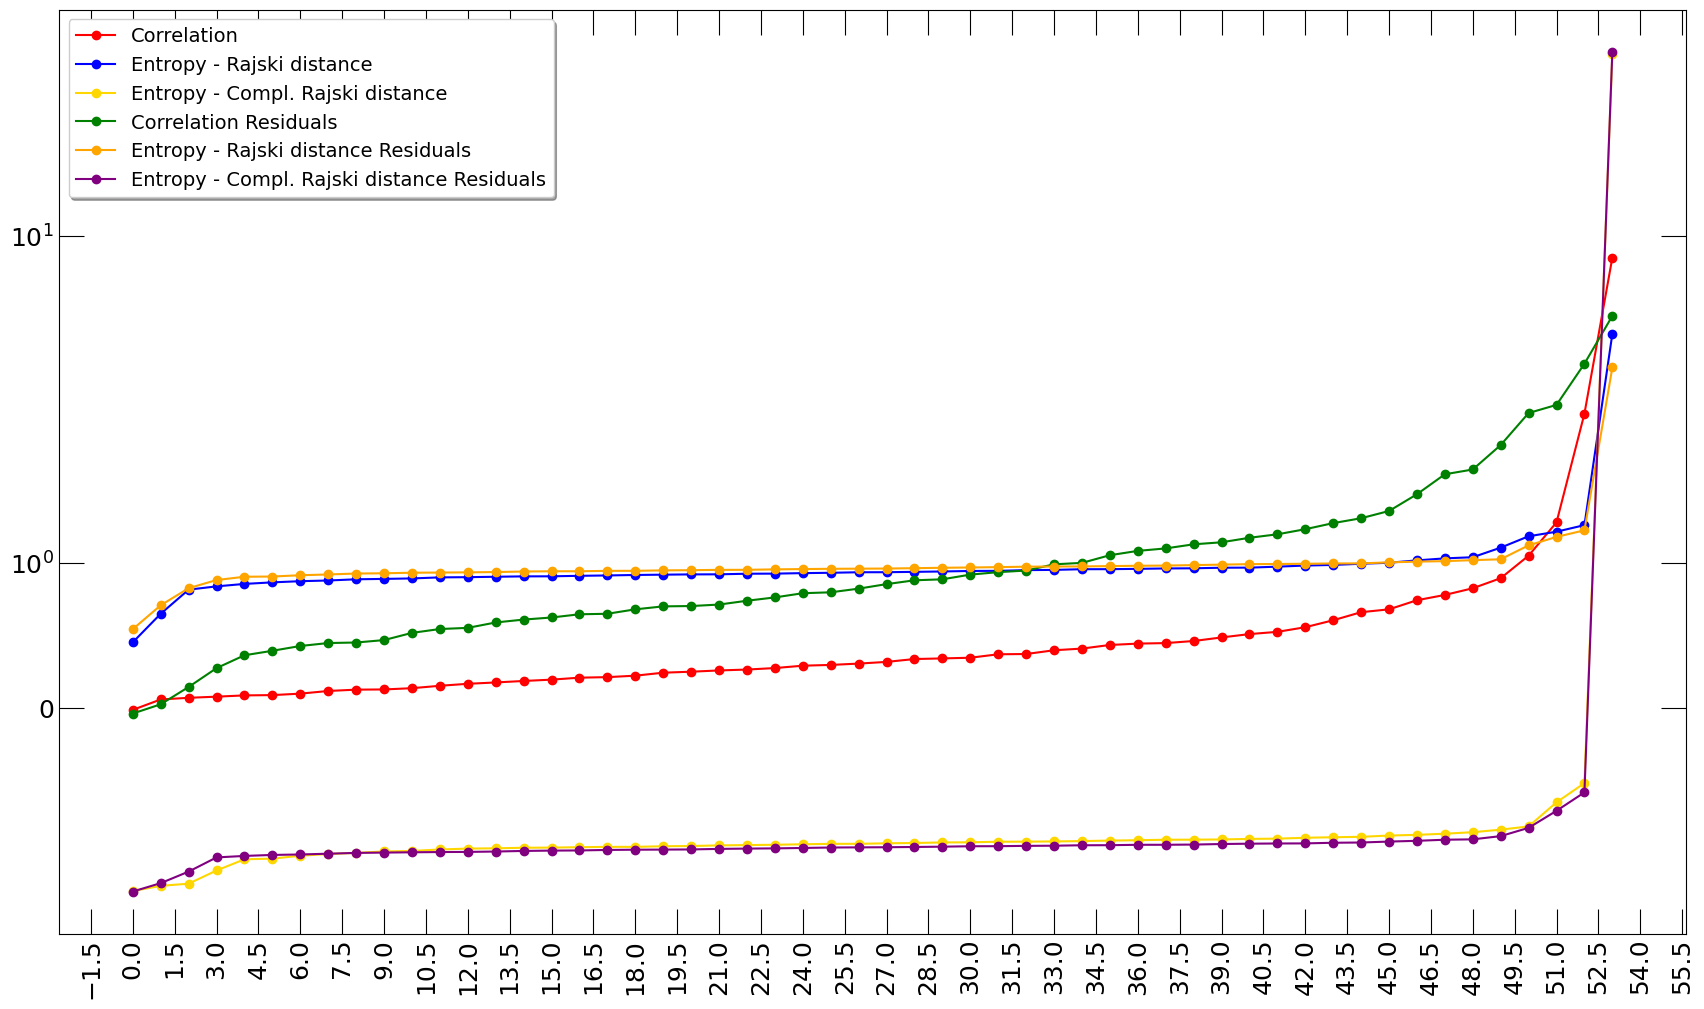

In [12]:
import matplotlib.pyplot as plt # type: ignore
import matplotlib.ticker as mtick # type: ignore

fig,ax = plt.subplots()
fig.set_size_inches(w = 21, h = 12)

df_8 = df_7#.tail(5)

ax.plot(df_8["eigenvalues_correlation"], color = "red", marker = "o", label = "Correlation")
ax.plot(df_8["eigenvalues_entropy"], color = "blue", marker = "o", label = "Entropy - Rajski distance")
ax.plot(df_8["eigenvalues_entropy_modified"], color = "gold", marker = "o", label = "Entropy - Compl. Rajski distance")
ax.plot(df_8["eigenvalues_correlation_res"], color = "green", marker = "o", label = "Correlation Residuals")
ax.plot(df_8["eigenvalues_entropy_res"], color = "orange", marker = "o", label = "Entropy - Rajski distance Residuals")
ax.plot(df_8["eigenvalues_entropy_modified_res"], color = "purple", marker = "o", label = "Entropy - Compl. Rajski distance Residuals")

ax.tick_params(which = "major", direction = "in", top = True, right = True, labelsize = 18, length = 18)
ax.tick_params(which = "minor", direction = "in", top = True, right = True, labelsize = 18, length = 10)
ax.xaxis.set_major_locator(mtick.MaxNLocator(df_5.shape[0]))
ax.yaxis.set_major_locator(mtick.MaxNLocator(40))
ax.tick_params(axis = "x", labelrotation = 90)
ax.legend(fancybox = True, shadow = True, ncol = 1, fontsize = 14)

#ax.set_xscale(value = "log")
ax.set_yscale(value = "symlog")

plt.show()


## Save data

In [13]:
df_final.to_csv("{}/df_entropy_correlation_gspc_{}.pkl".format(input_path_processed, re.sub("-", "", input_generation_date)), index = False)

#df_final.to_csv("{}/df_entropy_correlation_gspc_{}.pkl".format(input_path_processed, re.sub("-", "", input_generation_date)), index = False)

## Exploratory Data Analysis

symbol       date  EW      SWKS  temp_1    temp_2  mask
0      2000-01-04 NaN  0.000000     NaN  0.000000     1
1      2000-01-05 NaN  0.668527     NaN  0.668527     1
2      2000-01-06 NaN -2.706222     NaN -2.706222     1
3      2000-01-07 NaN  2.572648     NaN  2.572648     1
4      2000-01-10 NaN -1.478665     NaN -1.478665     1


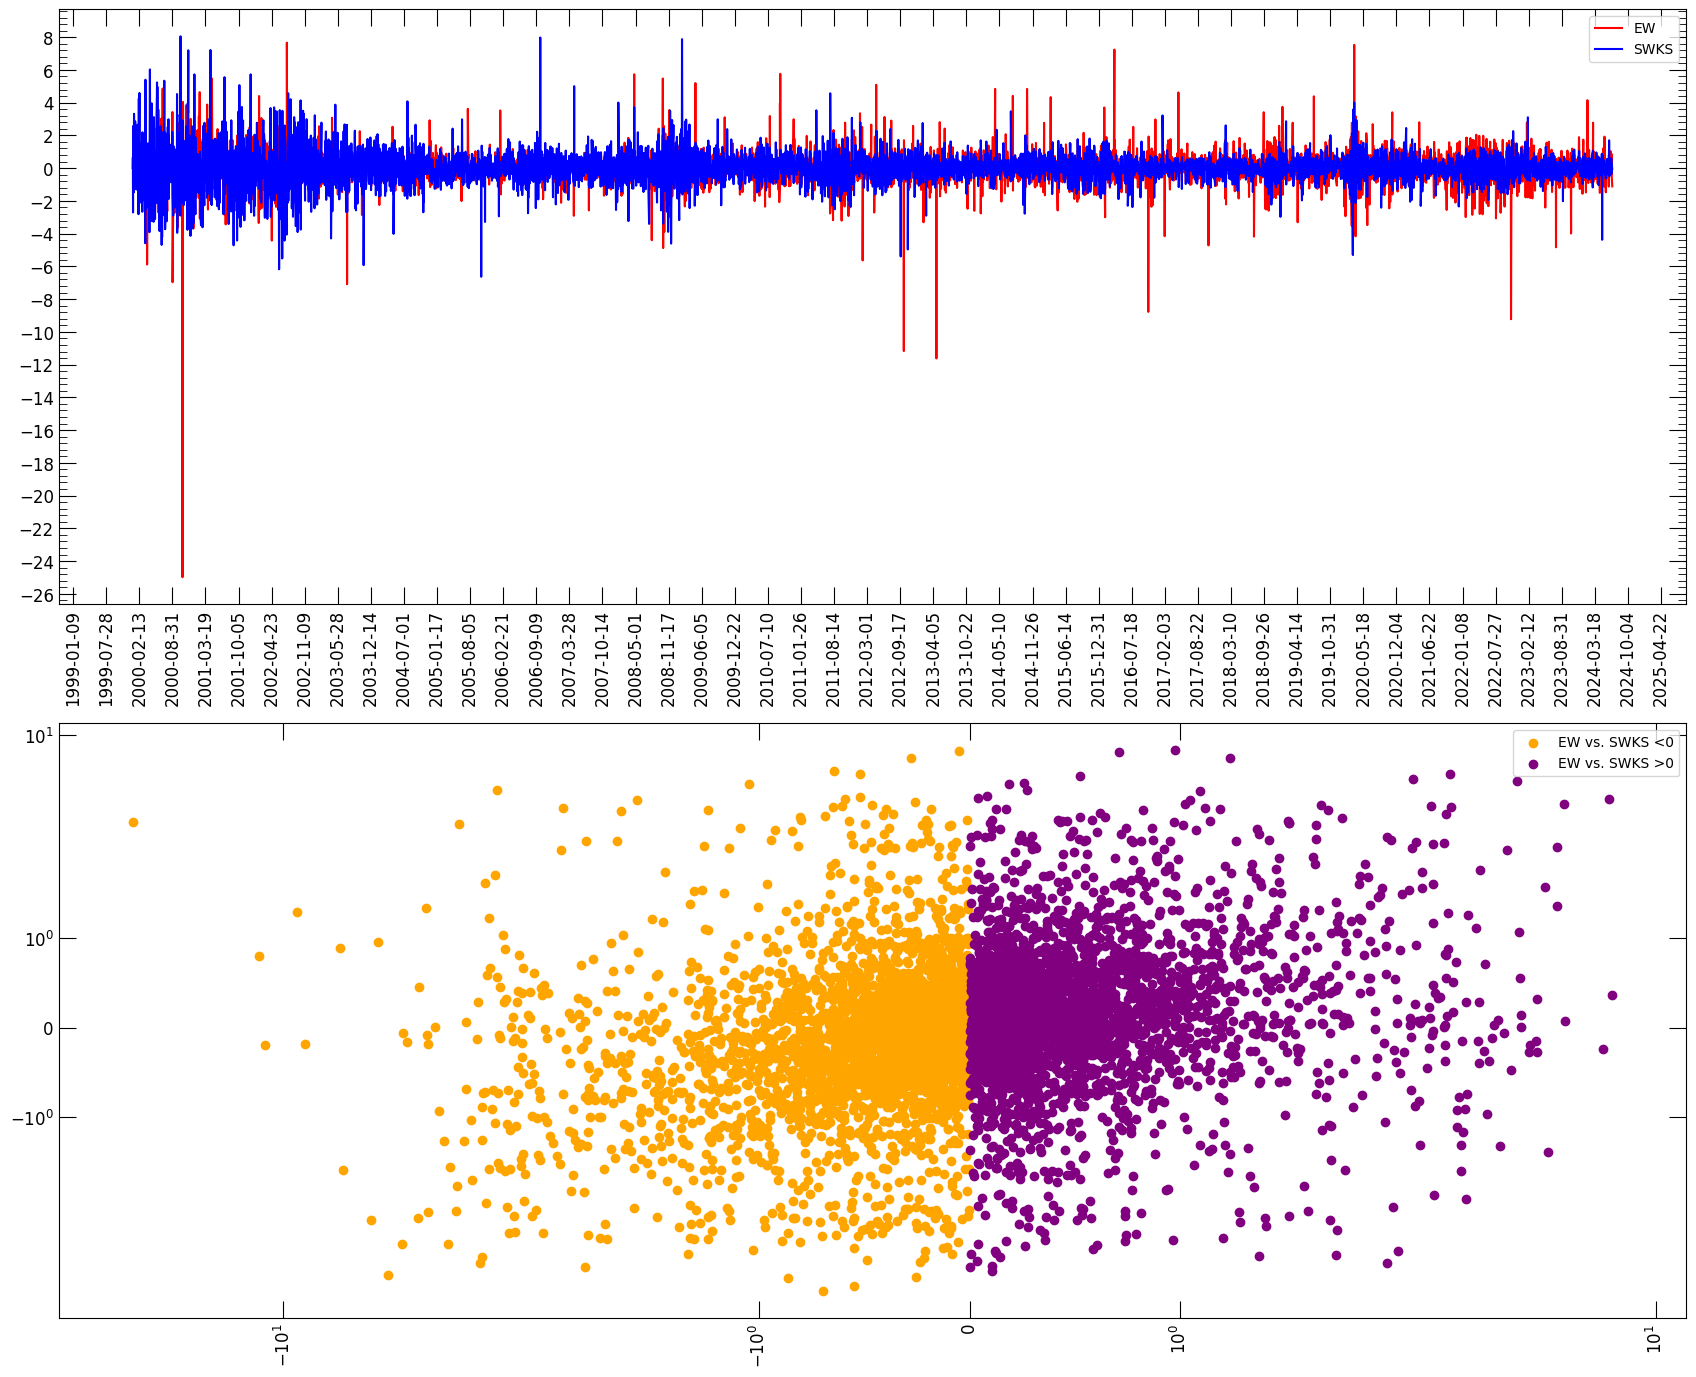

In [14]:
column_ = "z_score_log_return"

import matplotlib.pyplot as plt # type: ignore
import matplotlib.ticker as mtick # type: ignore

def symlog(x):
    if x >= 0:
        return np.log(x)
    else:
        return -np.log(-x)

fig,ax = plt.subplots(2,1)
fig.set_size_inches(w = 21, h = 17)

df_1 = df_stock_index[df_stock_index["symbol"] == shares_pair[0]]
df_2 = df_stock_index[df_stock_index["symbol"] == shares_pair[1]]
df_3 = (
    df_stock_index[df_stock_index["symbol"].isin(shares_pair)]
        .pivot(index = "date", columns = "symbol", values = column_)
        .reset_index()
)
df_3["temp_1"] = df_3[shares_pair[0]]#.apply(lambda x: symlog(x))
df_3["temp_2"] = df_3[shares_pair[1]]#.apply(lambda x: symlog(x))
df_3["mask"] = 1
df_3["mask"] = df_3["mask"].mask(cond = df_3[shares_pair[0]] < 0, other = 0)
#df_3 = df_3[((df_3[s1] <= df_3[s1].quantile(0.95)) & (df_3[s2] <= df_3[s2].quantile(0.95)))]
print(df_3.head())

ax[0].plot(df_1["date"], df_1[column_], color = "red", label = shares_pair[0])
ax[0].plot(df_2["date"], df_2[column_], color = "blue", label = shares_pair[1])
ax[1].scatter(df_3[df_3["mask"] == 0]["temp_1"], df_3[df_3["mask"] == 0]["temp_2"], color = "orange", label = "{} vs. {} <0".format(shares_pair[0], shares_pair[1]))
ax[1].scatter(df_3[df_3["mask"] == 1]["temp_1"], df_3[df_3["mask"] == 1]["temp_2"], color = "purple", label = "{} vs. {} >0".format(shares_pair[0], shares_pair[1]))
#ax[1].scatter(df_3[s1], df_3[s2], color = "orange", label = "{} vs. {}".format(s1, s2))

ax[0].tick_params(which = "major", direction = "in", top = True, right = True, labelsize = 12, length = 12)
ax[0].tick_params(which = "minor", direction = "in", top = True, right = True, labelsize = 12, length = 6)
ax[0].xaxis.set_major_locator(mtick.MaxNLocator(60))
ax[0].yaxis.set_major_locator(mtick.MaxNLocator(20))
ax[0].yaxis.set_minor_locator(mtick.MaxNLocator(5 * 20))
ax[0].tick_params(axis = "x", labelrotation = 90)
ax[0].legend()

ax[1].tick_params(which = "major", direction = "in", top = True, right = True, labelsize = 12, length = 12)
ax[1].tick_params(which = "minor", direction = "in", top = True, right = True, labelsize = 12, length = 6)
ax[1].xaxis.set_major_locator(mtick.MaxNLocator(40))
ax[1].xaxis.set_minor_locator(mtick.MaxNLocator(4 * 20))
ax[1].yaxis.set_major_locator(mtick.MaxNLocator(20))
ax[1].yaxis.set_minor_locator(mtick.MaxNLocator(5 * 20))
ax[1].tick_params(axis = "x", labelrotation = 90)
ax[1].legend()
ax[1].set_xscale(value = "symlog")
ax[1].set_yscale(value = "symlog")

plt.show()


symbol       date  EW      SWKS  temp_1    temp_2  mask
0      2000-01-04 NaN  0.000000     NaN  0.000000     1
1      2000-01-05 NaN  0.668527     NaN  0.668527     1
2      2000-01-06 NaN -2.706222     NaN -2.706222     1
3      2000-01-07 NaN  2.572648     NaN  2.572648     1
4      2000-01-10 NaN -1.478665     NaN -1.478665     1


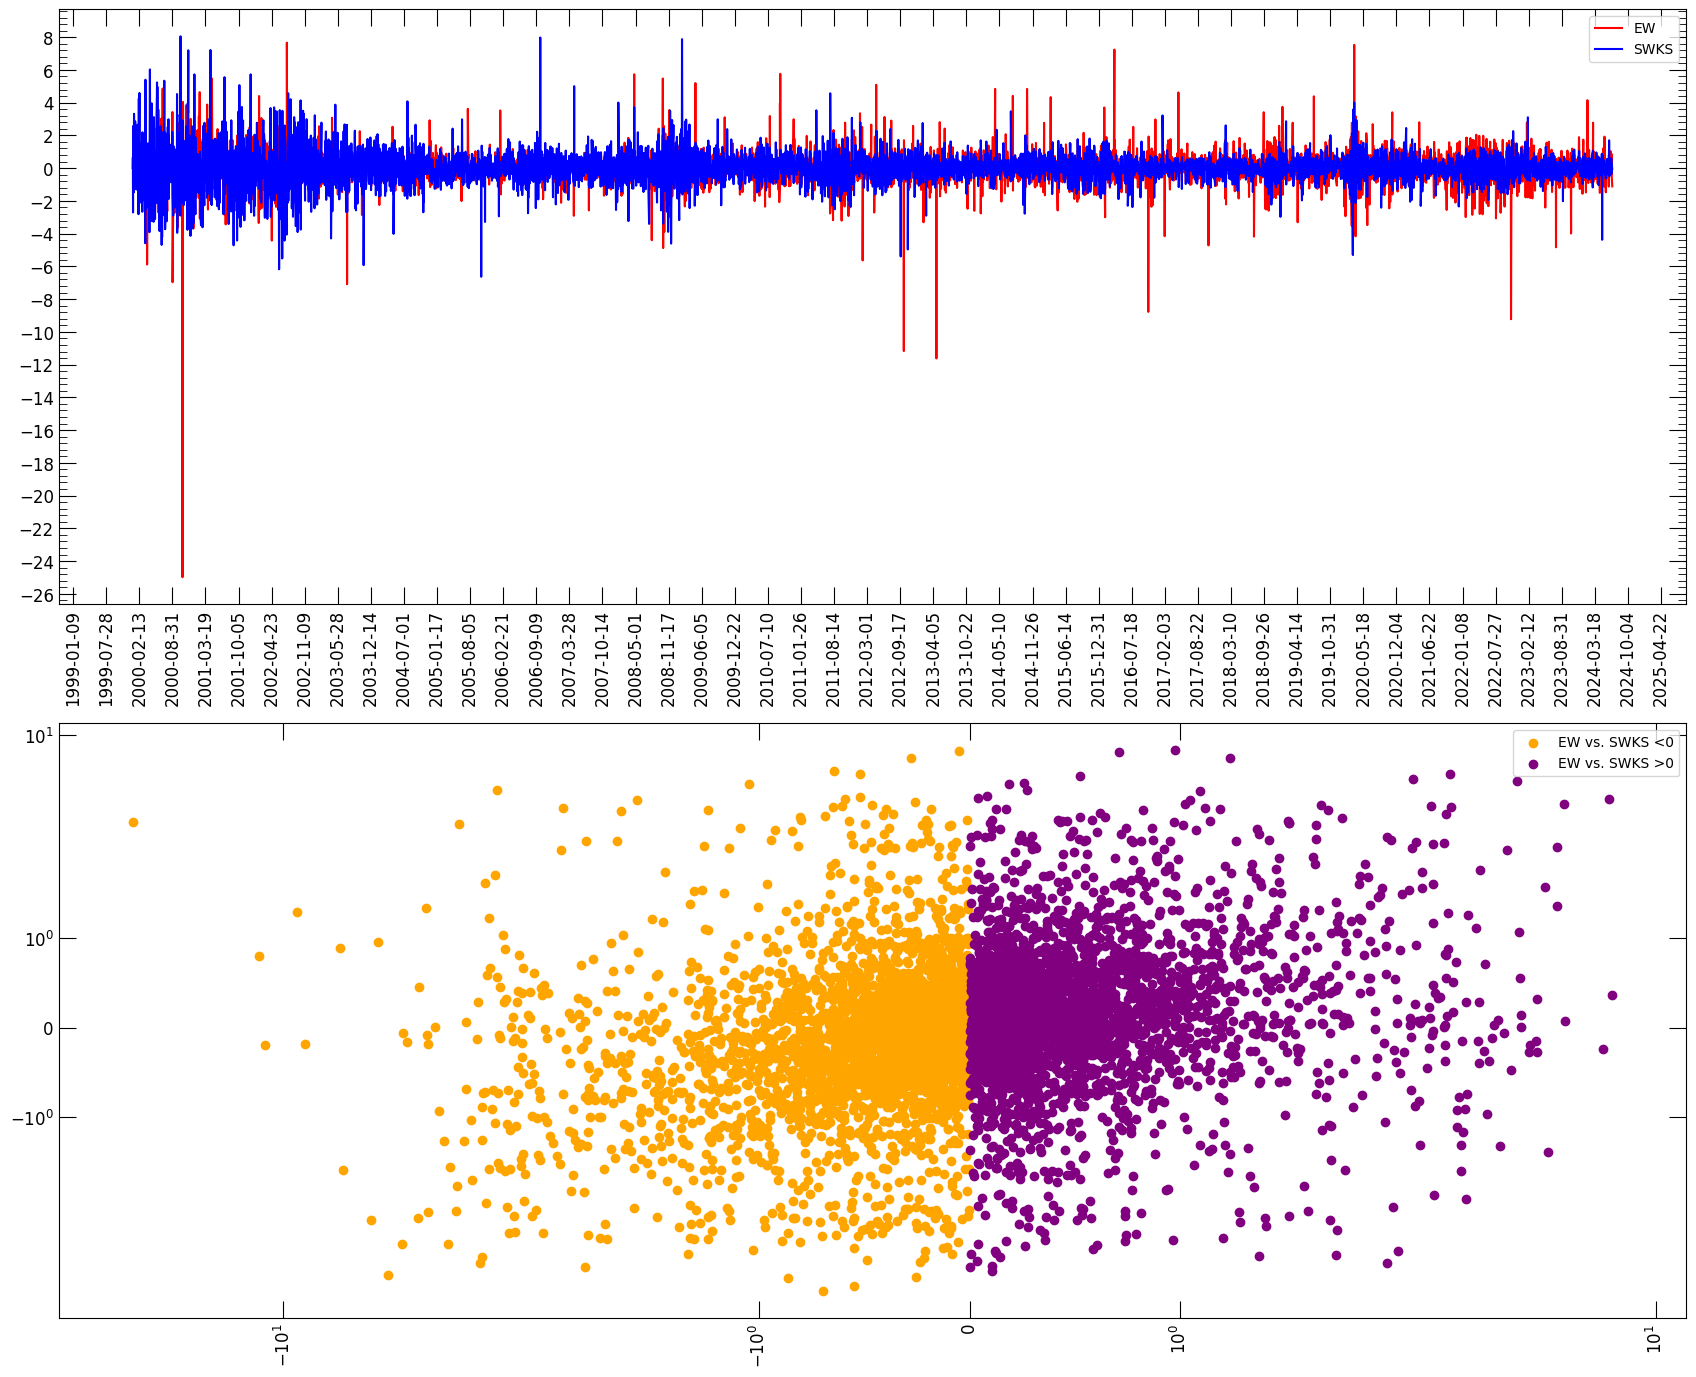

In [15]:
column_ = "z_score_log_return"

import matplotlib.pyplot as plt # type: ignore
import matplotlib.ticker as mtick # type: ignore

def symlog(x):
    if x >= 0:
        return np.log(x)
    else:
        return -np.log(-x)

fig,ax = plt.subplots(2,1)
fig.set_size_inches(w = 21, h = 17)

df_1 = df_stock_index[df_stock_index["symbol"] == shares_pair[0]]
df_2 = df_stock_index[df_stock_index["symbol"] == shares_pair[1]]
df_3 = (
    df_stock_index[df_stock_index["symbol"].isin(shares_pair)]
        .pivot(index = "date", columns = "symbol", values = column_)
        .reset_index()
)
df_3["temp_1"] = df_3[shares_pair[0]]#.apply(lambda x: symlog(x))
df_3["temp_2"] = df_3[shares_pair[1]]#.apply(lambda x: symlog(x))
df_3["mask"] = 1
df_3["mask"] = df_3["mask"].mask(cond = df_3[shares_pair[0]] < 0, other = 0)
#df_3 = df_3[((df_3[s1] <= df_3[s1].quantile(0.95)) & (df_3[s2] <= df_3[s2].quantile(0.95)))]
print(df_3.head())

ax[0].plot(df_1["date"], df_1[column_], color = "red", label = shares_pair[0])
ax[0].plot(df_2["date"], df_2[column_], color = "blue", label = shares_pair[1])
ax[1].scatter(df_3[df_3["mask"] == 0]["temp_1"], df_3[df_3["mask"] == 0]["temp_2"], color = "orange", label = "{} vs. {} <0".format(shares_pair[0], shares_pair[1]))
ax[1].scatter(df_3[df_3["mask"] == 1]["temp_1"], df_3[df_3["mask"] == 1]["temp_2"], color = "purple", label = "{} vs. {} >0".format(shares_pair[0], shares_pair[1]))
#ax[1].scatter(df_3[s1], df_3[s2], color = "orange", label = "{} vs. {}".format(s1, s2))

ax[0].tick_params(which = "major", direction = "in", top = True, right = True, labelsize = 12, length = 12)
ax[0].tick_params(which = "minor", direction = "in", top = True, right = True, labelsize = 12, length = 6)
ax[0].xaxis.set_major_locator(mtick.MaxNLocator(60))
ax[0].yaxis.set_major_locator(mtick.MaxNLocator(20))
ax[0].yaxis.set_minor_locator(mtick.MaxNLocator(5 * 20))
ax[0].tick_params(axis = "x", labelrotation = 90)
ax[0].legend()

ax[1].tick_params(which = "major", direction = "in", top = True, right = True, labelsize = 12, length = 12)
ax[1].tick_params(which = "minor", direction = "in", top = True, right = True, labelsize = 12, length = 6)
ax[1].xaxis.set_major_locator(mtick.MaxNLocator(40))
ax[1].xaxis.set_minor_locator(mtick.MaxNLocator(4 * 20))
ax[1].yaxis.set_major_locator(mtick.MaxNLocator(20))
ax[1].yaxis.set_minor_locator(mtick.MaxNLocator(5 * 20))
ax[1].tick_params(axis = "x", labelrotation = 90)
ax[1].legend()
ax[1].set_xscale(value = "symlog")
ax[1].set_yscale(value = "symlog")

plt.show()


## Proofs

In [16]:
#p_i = N df.shape[1] #Shares
#q = 1/2
#m = 225
#step = 8
#n_i = int((1/q)*p_i)
#delta = 20
#k1_k0 = 8

#for i in range(m):
#    print(i)
#    start = i*delta
#    end = i*delta + n_i # slicing in dates between start and end through "independent" Windows of size n_i
#    returns = data filtered into start and end date

df = df_stock_index
time_delta = 100
time_step = 20

market_args_list = df[["date"]].sort_values(by = ["date"]).value_counts(sort = False).reset_index()
market_args_list["final_date"] = market_args_list["date"] + pd.DateOffset(days = time_delta)
market_args_list = (
    market_args_list
        .rename(columns = {"date" : "initial_date"})
        .iloc[::time_step]
        .reset_index()
        .drop(columns = ["count", "index"])
)
market_args_list["initial_date"] = market_args_list["initial_date"].astype(str)
market_args_list["final_date"] = market_args_list["final_date"].astype(str)
market_args_list#.values.tolist()


,initial_date,final_date
0,2000-01-04,2000-04-13
1,2000-02-02,2000-05-12
2,2000-03-02,2000-06-10
3,2000-03-30,2000-07-08
4,2000-04-28,2000-08-06
...,...,...
304,2024-03-06,2024-06-14
305,2024-04-04,2024-07-13
306,2024-05-02,2024-08-10
307,2024-05-31,2024-09-08
